In [1]:
#!conda install -y quantecon
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5) #set default figure size
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

## Введение

Модель поиска работы Макколла помогает сформировать достаточно расплывчатое понятие "вынужденной" безработицы в терминах следующих факторов:
* Текущая и вероятная будущая зарплата
* Нетерпеливость 
* Пособие по безработице

Чтобы решить имеющуюся задачу, будем использовать методы динамического программирования. 

## Модель Макколла

Безработный агент в каждый момент времени t получает оффер в размере $w_t$ <br>
Функция офферов представляет собой неотрицательную функцию от некоторого состояния $s_t$:

<p style="text-align: center;">$w_t = w(s_t),$ где $s_t \in S$</p>

Для удобства можем рассматривать ${s_t}$, как некоторый неопределеный случайный фактор, который влияет на наши зарплаты (иными словами, можно представить $s$, как экзогенный стохастический процесс).

Мы вводим следующие предпосылки:
* ${s_t}$ - iid.
* $q(s)$ - вероятность наблюдать s в момент времени t
* экономический агент наблюдает $s_t$ в начале t и потому знает $w_t = w(s_t)$
* множество $S$ конечно


В момент времени t у агента есть на выбор 2 ~~стула~~ опции:
* принять оффер и дальше до конца жизни работать по ставке $w_t$
* отклонить оффер, получить компенсацию $c$ и подумать снова в t+1

Агент живет бесконечно долго и хочет максимизировать ожидаемую дисконтированную сумму дохода, выраженной в виде:

<p style="text-align: center;">$\mathbb{E}\sum_{t=0}^∞ {\beta^ty_t}$</p>

Константа $\beta$ лежит в интервале (0,1) и называется дисконтирующим фактором. Чем ее значение меньше, тем больше агент ценит текущий доход по сравнению с будущим. <br>
Переменная $y_t$, обозначающая доход, равна либо офферу ($w_t$), либо пособию ($c$).

Еще одно предположение: агент в курсе, что ${s_t}$ - iid с распределением $q$, и будет использовать имеющиеся знания при построении своего оптимального поведения.

    Таким образом, агент вынужден решать компромисс:
    * ждать слишком долго не вариант, поскольку будущее дисконтируется;
    * при этом не подождать может быть не выгодно, поскольку в будущем может выпасть сладкий оффер.

    Как уже было сказано, попробуем применить динамическое программирование со следующей процедурой:
    1. Присваиваем значения экзогенным величинам (об этом ниже)
    2. Приходим к оптимальному решению

### Функция значения

Чтобы все-таки решить задачу, надо бы иметь представление о двух вещах:
1. Текущие выплаты, которые мы получаем от различных опций.
2. Различные состояния, к которым ведут эти опции (в нашем случае, либо безработица, либо трудоустройство).<br>

Чтобы иметь численное представление проблемы выбора, нам нужно присвоить некоторые значения нашим переменным.

Пусть $v^*(s)$ будет значением функции, которая дает оптимальное решение в каждый момент времени $t$.
Иными словами, $v^*$ - функция, присваивающая каждому значению $s$ максимальную полезность, которая может быть получена от имеющегося оффера (и пособия).<br>


Мы это значение, конечно, посчитать пока не можем (поскольку не знаем, что представляют из себя оптимальные решения), но что известно - $v^*$ должна удовлетворять следующему рекуррентному уравнению:

<p style="text-align: center;">$v^*(s) = max\{\frac{w(s)}{1-\beta}, c + \beta \sum_{s' \in S} v^*(s')q(s')\}$</p>

для каждого $s \in S$, что является частным случаем уравнения Беллмана.

Нетрудно заметить, что первое значение в формуле - сумма бесконечной прогрессии, получающаяся от принятия текущего оффера. Второе же значение представляет собой выбор пособия + доход от оптимального поведения в будущем.

### Оптимальная стратегия

Штош, переходим к решению задачи. Имея под рукой функцию $v^*$, агент по идее может действовать оптимально. <br>
Правильнее всего воспринимать лучшее решение, как некоторый набор шагов (*стратегию*), что в общем-то представляет собой сопоставление (mapping) состояниям ($s$) действий. То есть, зная конкретное $s$, мы можем сделать наилучший выбор между опциями, выбрав максимум из двух значений в функции $v^*$ - принять (accept) оффер или отклонить его (reject).

Таким образом, мы имеем соответствие из $\mathbb{R}$ в $\{0,1\}$, где 1 и 0 означают принятие и отклонение, соответственно. Тогда описываемую стратегию можно записать в следующем в виде:

<p style="text-align: center;">$\sigma(s) := 1\{\frac{w(s)}{1-\beta} ≥ c + \beta \sum_{s' \in S} v^*(s')q(s')\}$</p>

Здесь $1\{P\} = 1$, если выражение $P$ - истина, и равно $0$, если ложно. <br>


Формулу выше можно записать другим способом:

<p style="text-align: center;">$\sigma(s) := 1\{w(s) ≥ \overline{w}\}$,</p> <br>
где 

<p style="text-align: center;">$\overline{w} = (1 - \beta)\{c + \beta \sum_{s' \in S} v^*(s')q(s')\}$</p>

Здесь $\overline{w}$ - константа, называемая резервной зарплатой и зависящая от $\beta$, $c$ и распределения зарплат.

Агент должен принимать оффер тогда и только тогда, когда $w(s)$ больше резервной зарплаты. Мы можем вычислить этот уровень резервной зарплаты, если посчитаем функцию значения.

## Просчитывание оптимальной стратегии (один из подходов).

Чтобы воплатить идею в действительность, нам нужно посчитать функцию значения для каждого $s \in S$.<br>
Предположим, что $S = \{1,...,n\}$. Функция значения тогда представляет собой вектор $v^* = (v^*(i))_{i=1}^n$ (для каждого значения $i = 1..n$).

Тогда перезапишем формулу для функции значения:

<p style="text-align: center;">$v^*(i) = max\{\frac{w(i)}{1-\beta}, c + \beta \sum_{1\le j \le n}v^*(j)q(j)\}$ for $i = 1..n$</p>

### Алгоритм подсчета

1. Выбираем какое-то начальное $v \in \mathbb{R}^n$.
2. Вычисляем новый вектор $v' \in \mathbb{R}^n$ с помощью
<p style="text-align: center;">$v'(i) = max\{\frac{w(i)}{1-\beta}, c + \beta \sum_{1\le j \le n}v(j)q(j)\}$ for $i = 1...n$</p>
3. Считаем меру отклонения между $v$ и $v'$ (например, $max_i |v(i)-v'(i)|$).
4. Если отклонение больше заранее заданной погрешности, то $v=v'$ и возврат ко 2 шагу, иначе шаг 5.
5. Возврат $v$.

Для небольшой, изначально заданной погрешности полученное $v$ - приблизительное значение $v^*$.

Наличие и единственность решения в поставленной задаче непосредственно соотносится с [теоремой Банаха о неподвижной точке](https://ru.wikipedia.org/wiki/Теорема_Банаха_о_неподвижной_точке).

## Реализация решения

Распределение состояний $S$ задается с помощью [Бета-биномиального закона](https://en.wikipedia.org/wiki/Beta-binomial_distribution).

In [5]:
n, a, b = 50, 200, 100 # параметры по умолчанию
q_default = BetaBinomial(n, a, b).pdf() # функция распределения s

In [6]:
# формирование значений случачйной величины зарплаты

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

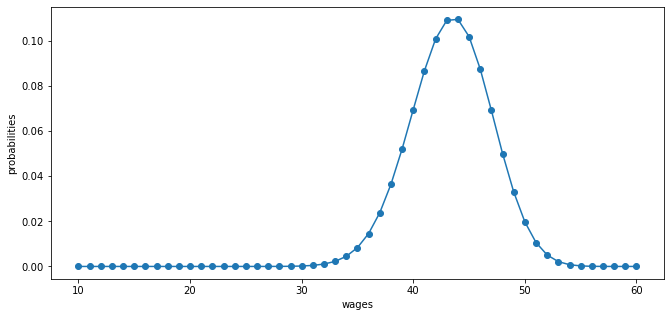

In [7]:
# график распределения 

fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()

In [8]:
mccall_data = [
('c', float64), # пособие по безработице
('β', float64), # дисконтирующий фактор
('w', float64[:]), # массив зарплат, w[i] = зарплата при s = i
('q', float64[:]) # массив вероятностей
]

Мы создадим класс, который будет хранить данные и вычислять значения для каждой пары состояние(s)-действие, то есть выдавать значение правой части уравнения из пункта "Алгоритм подсчета". Значения по умолчанию будут лежать  в полях класса.


\*Реализация нашего решения является итеративным процессом, на каждом шаге которого мы будем выполнять несколько математических операций. Стоит ожидать, что процесс приближенция к стационарному состоянию может быть вычислительно трудоемким. В связи с этим в данном ноутбуке будет использоваться пакет [numba](https://habr.com/ru/post/484136/) (в частности, декораторы @jitclass и @jit позаимствованы оттуда) - *прим. перевод.*

In [9]:
@jitclass(mccall_data)
class McCallModel:
    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):
        self.c, self.β = c, β
        self.w, self.q = w_default, q_default
    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # подсчитываем значения
        # приходим к выбору = принять или отклонить оффер
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)
        
        return np.array([accept, reject])

Изначальным значением для $v$ будет $v(i) = \frac{w(i)}{1-\beta}$

In [11]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Строим последовательность функций значения.
        * mcm - экземпляр класса McCallModel
        * ax - как аргумент функции прокидывается холст для графиков
    """
    
    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
            v[:] = v_next # copy contents into v
            ax.legend(loc='lower right')

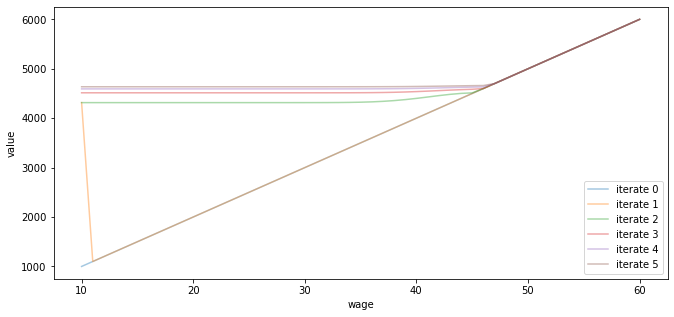

In [12]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

    Сходимость к определенному значению визуально видна. Но у нас выше только 6 итераций; стоит все-таки дойти до конца согласно изначальному плану. Как только мы дойдем до приблизительного предельного значения, мы сможем посчитать уровень резервной зп.

In [15]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
    max_iter=500,
    tol=1e-6):
    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
    # == First compute the value function == #
    n = len(w)
    v = w / (1 - β) # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
            error = np.max(np.abs(v_next - v))
            i += 1
            v[:] = v_next # copy contents into v
            # == Now compute the reservation wage == #
    return (1 - β) * (c + β * np.sum(v * q))

In [16]:
# резервная зарплата

compute_reservation_wage(mcm)

45.139315268589094

Если мы зададимся вопросом, как меняется решение при использовании различных значений параметров, то мы можем это явно посмотреть. Например, если нас интересует изменение ответа при изменении констант $\beta$ и $c$.

In [19]:
grid_size = 25
R = np.empty((grid_size, grid_size))
c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)
for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

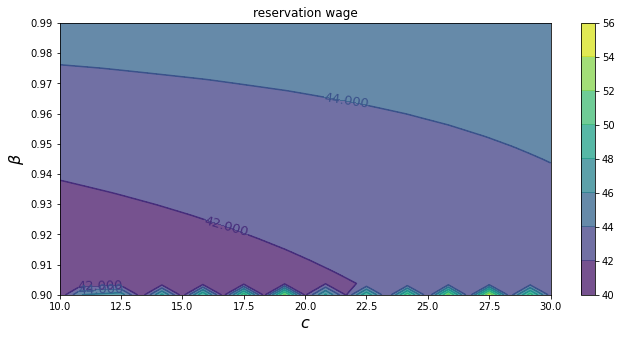

In [20]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)

plt.show()

Как и ожидалось, уровень резервной заработной платы растет при увеличении $\beta$ (мы его интерпретируем как "желание ожидать") и пособия по безработице.